In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas  # noqa
import scipy.io as sio

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from src.parameters import ANIMALS

epoch_key = ('jaq', 1, 2)

In [89]:
# alternative
from loren_frank_data_processing import Animal
ANIMALS = {
    'bill': Animal(directory=('/stelmo/mcoulter/bill/filterframework/'), short_name='bill'),
}
epoch_key = ('bill',7,2)

In [ ]:
from loren_frank_data_processing.position import _get_pos_dataframe

position_info1 = _get_pos_dataframe(epoch_key, ANIMALS)

position_info1

In [5]:
position_info.hvplot.line('x_position', 'y_position', height=500, width=500)

:Curve   [x_position]   (y_position)

In [ ]:
# old code from remy Sungod - to figure out how to re-create the linearized position
node_ref = '/home/mcoulter/spykshrk_realtime/set_arm_nodes.mat'
#node_ref = linearization_path + 'set_arm_nodes.mat'
linearcoord = sio.loadmat(node_ref)['linearcoord_one_box'][0]

#animalinfo  = {animal: Animal(directory=raw_path, short_name=animal)}
#epoch_key = (animal, day, epoch)
#position_info = lfdp.position._get_pos_dataframe(epoch_key, animalinfo)

center_well_position = linearcoord[0][0]
nodes = [center_well_position[np.newaxis, :]]

for arm in linearcoord: 
    for point in arm[1:]:
        nodes.append(point[np.newaxis, :])
nodes = np.concatenate(nodes)

dist = []
for arm in linearcoord:
    dist.append(np.linalg.norm(np.diff(arm, axis=0), axis=1))
np.stack([*dist])

edges = [(0, 1),(1, 2),(0, 3),(3, 4),(0, 5),(5, 6),(0, 7),(7, 8),
        (0, 9),(9, 10),(0, 11),(11, 12),(0, 13),(13, 14),(0, 15),(15, 16)]
edge_distances = np.concatenate([*dist])

track_graph = nx.Graph()
for node_id, node_position in enumerate(nodes):
    track_graph.add_node(node_id, pos=tuple(node_position))
for edge, distance in zip(edges, edge_distances):
    track_graph.add_edge(edge[0], edge[1], distance=distance)
#lfdp.track_segment_classification.plot_track(track_graph)

position = position_info.loc[:, ['x_position', 'y_position']].values

track_segment_id = lfdp.track_segment_classification.classify_track_segments(
        track_graph, position,
        route_euclidean_distance_scaling=1,
        sensor_std_dev=1)

center_well_id = 0
linear_distance = lfdp.track_segment_classification.calculate_linear_distance(
            track_graph, track_segment_id, center_well_id, position)

    # this section calculates the shift amounts for each arm
arm_distances = (edge_distances[1],edge_distances[3],edge_distances[5],edge_distances[7],
                    edge_distances[9],edge_distances[11],edge_distances[13],edge_distances[15])

shift_linear_distance_by_arm_dictionary = dict() # initialize empty dictionary 

hardcode_armorder = [0,1,2,3,4,5,6,7]

for arm in enumerate(hardcode_armorder): # for each outer arm
    if arm[0] == 0: # if first arm, just shift hardcode_shiftamount
        temporary_variable_shift = gap_size
    else: # if not first arm, add to hardcode_shiftamount length of previous arm 
        temporary_variable_shift = gap_size + arm_distances[arm[0]] + shift_linear_distance_by_arm_dictionary[hardcode_armorder[arm[0] - 1]]
    shift_linear_distance_by_arm_dictionary[arm[1]] = temporary_variable_shift

    # Modify: 1) collapse non-arm locations (segments 0-7), 
    # 2) shift linear distance for the 8 arms (segments 8-15)
newseg = np.copy(track_segment_id)
newseg[(newseg < 8)] = 0

    # 2) Shift linear distance for each arm 
linear_distance_arm_shift = np.copy(linear_distance)
for seg in shift_linear_distance_by_arm_dictionary:
    linear_distance_arm_shift[(newseg==(seg+8))]+=shift_linear_distance_by_arm_dictionary[(seg)]  

#save outputs
output_base = linearization_path + animal + '_' + str(day) + '_' +str(epoch) + '_'
lin_output1 = output_base + 'linearized_distance.npy'
lin_output2 = output_base + 'linearized_track_segments.npy'
#lin_output3 = output_base + 'linearization_variables.mat'
np.save(lin_output1, linear_distance_arm_shift)
np.save(lin_output2, track_segment_id)

In [4]:
# new code for realtime SunGod linearization
import loren_frank_data_processing as lfdp
from loren_frank_data_processing import Animal
import networkx as nx

animalinfo = {'bill': Animal(directory=('/stelmo/mcoulter/bill/filterframework/'), short_name='bill')}
epoch_key = ('bill',7,2)

#animalinfo  = {animal: Animal(directory=raw_path, short_name=animal)}
#epoch_key = (animal, day, epoch)
position_info = lfdp.position._get_pos_dataframe(epoch_key, animalinfo)

nodes = np.array([
    (169.1, 108), # home
    (140, 110.2), # past center
    (122, 95.8), # start arm 1
    (119, 106.2), # start arm 2
    (121, 115.4),  # start arm 3
    (124.5, 125), # start arm 4 
    (51.4, 88.2), # end arm 1
    (49.5, 109.2),  # end arm 2 
    (52.8, 130),  # end arm 3
    (61.1, 152.5), # end arm 4
])

edges = np.array([
    (0, 1),
    (1, 2),
    (1, 3),
    (1, 4),
    (1, 5),
    (2, 6),
    (3, 7),
    (4, 8),
    (5, 9),
])

track_segments = np.array([(nodes[e1], nodes[e2]) for e1, e2 in edges])
edge_distances = np.linalg.norm(
    np.diff(track_segments, axis=-2).squeeze(), axis=1)

track_graph = nx.Graph()
for node_id, node_position in enumerate(nodes):
    track_graph.add_node(node_id, pos=tuple(node_position))
#old:
#for edge, distance in zip(edges, edge_distances):
#    track_graph.add_edge(edge[0], edge[1], distance=distance)

# new
for edge, distance in zip(edges, edge_distances):
    nx.add_path(track_graph, edge, distance=distance)

#lfdp.track_segment_classification.plot_track(track_graph)

position = position_info.loc[:, ['x_position', 'y_position']].values

track_segment_id = lfdp.track_segment_classification.classify_track_segments(
        track_graph, position,
        route_euclidean_distance_scaling=1,
        sensor_std_dev=1)

center_well_id = 0
linear_distance = lfdp.track_segment_classification.calculate_linear_distance(
            track_graph, track_segment_id, center_well_id, position)

# this section calculates the shift amounts for each arm
arm_distances = (edge_distances[5:9])

shift_linear_distance_by_arm_dictionary = dict()
# this order is used to shift the linear distances
hardcode_armorder = [0,1,2,3,4,5,6,7,8]
# add this gap to sum of previous shifts (was 20 for 1cm)
hardcode_shiftamount = 20

for arm in hardcode_armorder:
    # home to wait
    if arm == 0:
        temporary_variable_shift = 0

    # outer half of box - also no shift
    elif arm > 0 and arm < 5:
        temporary_variable_shift = 0

    # first outer arm - 52 is max value in box area
    elif arm == 5:
        temporary_variable_shift = hardcode_shiftamount + 52
            
    # outer arms - add length of previous arm
    else:
        temporary_variable_shift = hardcode_shiftamount + arm_distances[arm-6] + shift_linear_distance_by_arm_dictionary[hardcode_armorder[arm - 1]]
            
    shift_linear_distance_by_arm_dictionary[arm] = temporary_variable_shift

# 2) Shift linear distance for each arm 
linear_distance_arm_shift = np.copy(linear_distance)
for seg in shift_linear_distance_by_arm_dictionary:
    linear_distance_arm_shift[(track_segment_id==(seg))]+=shift_linear_distance_by_arm_dictionary[(seg)]

#save outputs
linearization_path = '/stelmo/mcoulter/bill/filterframework/'
animal = 'bill'
day = 7
epoch = 2

output_base = linearization_path + animal + '_' + str(day) + '_' +str(epoch) + '_'
lin_output1 = output_base + 'linearized_distance.npy'
lin_output2 = output_base + 'linearized_track_segments.npy'
#lin_output3 = output_base + 'linearization_variables.mat'
np.save(lin_output1, linear_distance_arm_shift)
np.save(lin_output2, track_segment_id)

NameError: name 'animal' is not defined

In [16]:
print(edge_distances)
arm_distances = (edge_distances[1],edge_distances[3],edge_distances[5],edge_distances[7],
                    edge_distances[9],edge_distances[11],edge_distances[13],edge_distances[15])
print(arm_distances)

[44.97879438 64.31076998 41.70184597 66.12651774 40.63572205 65.8231001
 42.73056474 64.94545262 42.30695774 64.4210335  41.53541337 63.0380093
 42.79109401 61.05929981 41.8031779  62.35993738]
(64.31076997762862, 66.12651773717477, 65.82310009788122, 64.94545261983757, 64.42103350481032, 63.038009300507106, 61.059299807401736, 62.35993738023735)


<IPython.core.display.Javascript object>


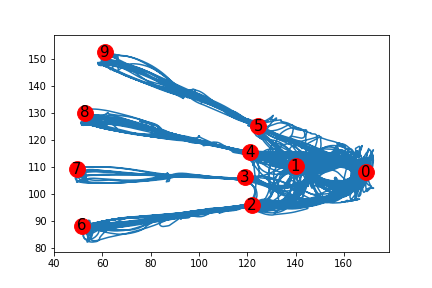

In [91]:
node_positions = np.array([
    (169.1, 108), # home
    (140, 110.2), # past center - i think (140,110.2) is good, but cant tell if it actually changed anything
    (122, 95.8), # start arm 1
    (119, 106.2), # start arm 2
    (121, 115.4),  # start arm 3
    (124.5, 125), # start arm 4 
    (51.4, 88.2), # end arm 1
    (49.5, 109.2),  # end arm 2 
    (52.8, 130),  # end arm 3
    (61.1, 152.5), # end arm 4
])

edges = np.array([
    (0, 1),
    (1, 2),
    (1, 3),
    (1, 4),
    (1, 5),
    (2, 6),
    (3, 7),
    (4, 8),
    (5, 9),
])

track_segments = np.array([(node_positions[e1], node_positions[e2]) for e1, e2 in edges])
edge_distances = np.linalg.norm(
    np.diff(track_segments, axis=-2).squeeze(), axis=1)
arm_distances = (edge_distances[5:9])

plt.plot(position_info1.x_position, position_info1.y_position)
plt.scatter(node_positions[:, 0], node_positions[:, 1], color='red', zorder=10, s=250)
for i, (x, y) in enumerate(node_positions):
    plt.text(x, y, i, zorder=10, ha='center', va='center', fontsize=15, color='black')

In [20]:
arm_distances

array([71.00788689, 69.56471807, 69.74525073, 69.10723551])

<IPython.core.display.Javascript object>


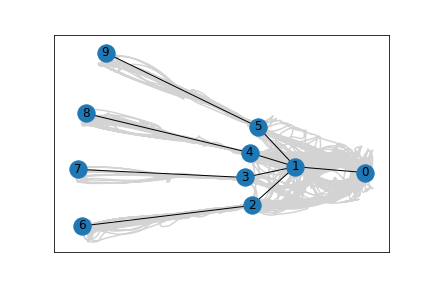

In [92]:
import networkx as nx
from loren_frank_data_processing.track_segment_classification import plot_track

track_graph = nx.Graph()

for node_id, node_position in enumerate(node_positions):
    track_graph.add_node(node_id, pos=tuple(node_position))

for edge, distance in zip(edges, edge_distances):
    nx.add_path(track_graph, edge, distance=distance)
    
plt.plot(position_info1.x_position, position_info1.y_position, color='lightgrey', zorder=-1)    
plot_track(track_graph)

In [93]:
# use this cell to generate track_segment_id
# how do you add track_segment_id to position_info?
from loren_frank_data_processing.track_segment_classification import classify_track_segments

position = position_info1.loc[:, ['x_position', 'y_position']].values

track_segment_id = classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=0.1,
    sensor_std_dev=10)

In [94]:
position_info1['track_segment_id'] = track_segment_id

In [65]:
fig, ax = plt.subplots(figsize=(8, 9))

for edge_label, df in position_info.groupby('track_segment_id'):
    ax.scatter(df.x_position, df.y_position, s=10, alpha=0.7, label=edge_label)
plt.legend()
plt.axis('square');

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


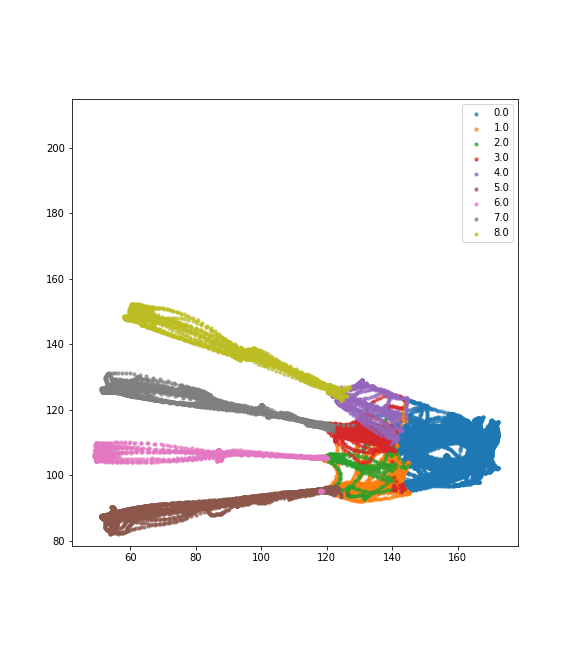

In [95]:
fig, ax = plt.subplots(figsize=(8, 9))

for edge_label, df in position_info1.groupby('track_segment_id'):
    ax.scatter(df.x_position, df.y_position, s=10, alpha=0.7, label=edge_label)
plt.legend()
plt.axis('square');

In [102]:
shift_linear_distance_by_arm_dictionary

{0: 0,
 1: 30,
 2: 30,
 3: 30,
 4: 30,
 5: 70,
 6: 161.00788688589458,
 7: 250.57260495475475,
 8: 340.31785568912375}

In [96]:
# use this cell to generate linear_distance

from loren_frank_data_processing.track_segment_classification import calculate_linear_distance

center_well_id = 0

linear_distance = calculate_linear_distance(
    track_graph, track_segment_id, center_well_id, position)

<IPython.core.display.Javascript object>


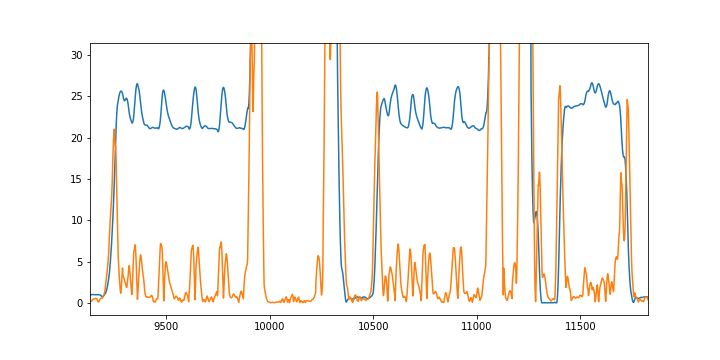

In [53]:

plt.figure(figsize=(10,5))
plt.plot(linear_distance)
plt.plot(position_info['speed'].values)

<IPython.core.display.Javascript object>


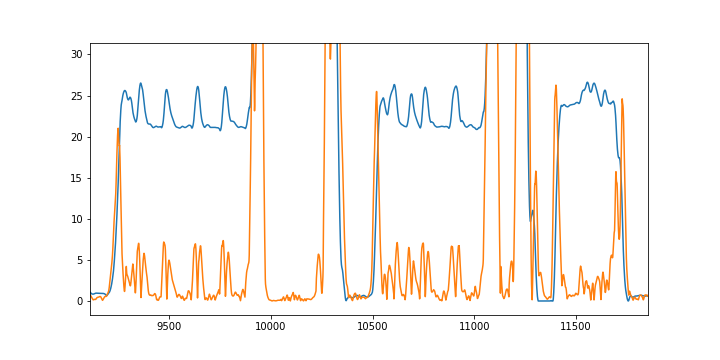

In [88]:
#moved rip/wait farther from home - want to see if head bob goes away
# nope its exactly the same - okay so these head bobs are real - not a result of linearization
plt.figure(figsize=(10,5))
plt.plot(linear_distance)
plt.plot(position_info['speed'].values)

<IPython.core.display.Javascript object>


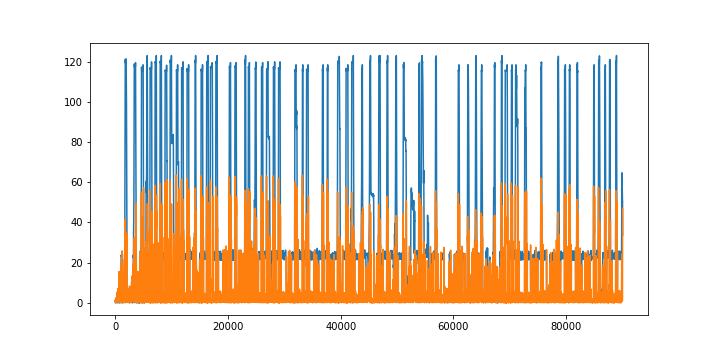

In [97]:
# day 7 2019-12-18
plt.figure(figsize=(10,5))
plt.plot(linear_distance)
plt.plot(position_info1['speed'].values)

In [103]:
position_info1['linear_distance'] = linear_distance

In [107]:
position_info1[position_info1['track_segment_id']==1]

x_position  y_position  head_direction      speed  \
time                                                                 
00:16:45.050373  142.983232  103.512355        0.425406  16.179729   
00:16:45.084015  142.723299  102.892872        0.464424  16.776814   
00:16:45.117624  142.477757  102.302134        0.497120  17.059077   
00:16:45.151232  142.237161  101.731018        0.523252  17.058649   
00:16:45.184874  142.001305  101.185002        0.543283  16.791042   
00:16:45.218482  141.766039  100.657682        0.556650  16.424942   
00:16:45.252090  141.537705  100.148397        0.563604  15.963909   
00:16:45.285732  141.309106   99.661014        0.563472  15.500126   
00:16:45.319340  141.080382   99.199055        0.556986  15.048190   
00:16:45.352948  140.852086   98.762968        0.545577  14.638338   
00:16:45.386590  140.624968   98.350346        0.533263  14.297478   
00:16:45.420198  140.394716   97.967284        0.522946  14.141725   
00:16:45.453806  140.150518   97.622649        0.513992  14.308150   
00:16:45.487448  139.892525   97.310494        0.505052  14.718389   
00:16:45.521056  139.608975   97.001825        0.495473  15.179361   
00:16:45.554664  139.346135   96.711047        0.484917  15.918817   
00:16:45.588306  139.033956   96.395754        0.473138  16.701988   
00:16:45.621914  138.638591   96.080609        0.458678  17.481250   
00:16:45.655522  138.180929   95.769854        0.442418  18.348971   
00:16:45.689164  137.661994   95.474075        0.424017  19.273365   
00:16:45.722772  137.082766   95.188098        0.405001  20.237555   
00:16:45.756380  136.437419   94.911877        0.383408  21.165878   
00:16:45.789988  135.721623   94.655001        0.360943  21.989904   
00:16:45.823630  134.942339   94.434390        0.338144  22.721369   
00:16:45.857239  134.114870   94.255235        0.314199  23.388769   
00:16:45.890847  133.220254   94.110133        0.282774  23.998431   
00:16:45.924489  132.287182   94.005963        0.225298  24.643032   
00:16:45.958097  131.335924   93.938557        0.180316  25.292494   
00:16:45.991705  130.352537   93.908198        0.141249  25.937985   
00:16:46.025347  129.344259   93.915418        0.105505  26.563308   
...                     ...         ...             ...        ...   
01:05:44.782849  136.083968  103.872870        0.357525  18.664695   
01:05:44.816457  135.884894  103.287892        0.384683  19.160966   
01:05:44.850099  135.751879  102.681741        0.399330  19.549657   
01:05:44.883708  135.611369  102.072514        0.403708  19.897866   
01:05:44.917316  135.374096  101.481035        0.393263  20.359090   
01:05:44.950959  135.040225  100.915945        0.375401  20.953965   
01:05:44.984567  134.591661  100.362097        0.354742  21.801080   
01:05:45.018175  134.046909   99.808458        0.332860  22.840152   
01:05:45.051818  133.418635   99.256360        0.309640  23.971131   
01:05:45.085426  132.716506   98.709991        0.286778  25.146217   
01:05:45.119035  131.941796   98.183672        0.265513  26.364229   
01:05:45.152677  131.084326   97.672179        0.245316  27.667357   
01:05:45.186285  130.168352   97.176124        0.218319  29.095288   
01:05:45.219894  129.194915   96.706126        0.196301  30.571892   
01:05:45.253536  128.167567   96.288918        0.179087  31.956709   
01:05:45.287145  127.079818   95.928166        0.168217  33.262336   
01:05:45.320753  125.947506   95.634008        0.162197  34.501815   
01:05:45.354395  124.774751   95.399815        0.153722  35.749373   
01:05:51.372236  121.436852   95.656038       -2.963224  47.555102   
01:05:51.405879  123.056578   95.714308       -2.977555  48.201264   
01:05:51.439487  124.713957   95.756194       -2.988656  48.750459   
01:05:51.473095  126.366137   95.798449       -2.998314  49.213189   
01:05:51.506738  128.030510   95.842173       -3.005483  49.602089   
01:05:51.540346  129.724351   95.884293       -3.008927  49.895422   
01:05:51.573955  131.418089

In [109]:
plt.figure(figsize=(10,5))
plt.plot(position_info1[position_info1['track_segment_id']==1]['linear_distance'].values)
plt.plot(position_info1[position_info1['track_segment_id']==2]['linear_distance'].values)
plt.plot(position_info1[position_info1['track_segment_id']==3]['linear_distance'].values)
plt.plot(position_info1[position_info1['track_segment_id']==4]['linear_distance'].values)

<IPython.core.display.Javascript object>

In [110]:
# use this cell to generate arm shift dictionary
# use code from spykshrk realtime camera_process

shift_linear_distance_by_arm_dictionary = dict()
# new way with 8 parallel segments for box
# this order is used to shift the linear distances
hardcode_armorder = [0,1,2,3,4,5,6,7,8]
# add this gap to sum of previous shifts (was 20 for 1cm)
hardcode_shiftamount = 20
# for now set all arm lengths to 60 for 1cm (12 for 5cm)
# dont use this, use measured distance of previous arm
# linearization_arm_length = 12

for arm in hardcode_armorder:
    # home to wait
    if arm == 0:
        temporary_variable_shift = 0

    # outer half of box - also no shift
    elif arm > 0 and arm < 5:
        temporary_variable_shift = 0

    # first outer arm - 52 is max value in box area
    elif arm == 5:
        temporary_variable_shift = hardcode_shiftamount + 52
            
    # outer arms - add length of previous arm
    else:
        temporary_variable_shift = hardcode_shiftamount + arm_distances[arm-6] + shift_linear_distance_by_arm_dictionary[hardcode_armorder[arm - 1]]
            
    shift_linear_distance_by_arm_dictionary[arm] = temporary_variable_shift
    #print(self.shift_linear_distance_by_arm_dictionary)

# use shift_linear dictionary to shift linear position
#position_info['track_segment_id']

# real-time position assignment - dont use
# but we actually want to use the position assignment for offline that anna made
#if segment == 0:
#    self.assigned_pos = math.floor(segment_pos*6 + self.shift_linear_distance_by_arm_dictionary[segment])
#    if self.assigned_pos == 6:
#        self.assigned_pos = 5
#elif segment > 0 and segment < 5:
#    self.assigned_pos = math.floor(segment_pos*4 + self.shift_linear_distance_by_arm_dictionary[segment])
#    if self.assigned_pos == 9:
#        self.assigned_pos = 8
#else:
#    self.assigned_pos = math.ceil(segment_pos*12 + self.shift_linear_distance_by_arm_dictionary[segment])



In [111]:
shift_linear_distance_by_arm_dictionary

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 72,
 6: 163.00788688589458,
 7: 252.57260495475475,
 8: 342.31785568912375}

In [112]:
# use this cell to generate linear_distance_arm_shift
linear_distance_arm_shift = np.copy(linear_distance)
for seg in shift_linear_distance_by_arm_dictionary:
    linear_distance_arm_shift[(track_segment_id==(seg))]+=shift_linear_distance_by_arm_dictionary[(seg)]


In [52]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.plot(linear_distance_arm_shift)
plt.plot(position_info['speed'].values)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


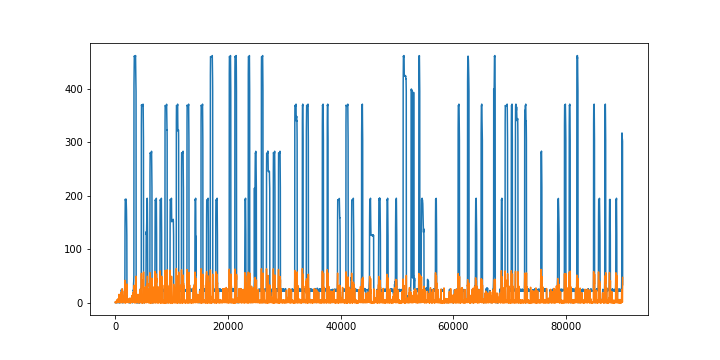

In [113]:
plt.figure(figsize=(10,5))
plt.plot(linear_distance_arm_shift)
plt.plot(position_info1['speed'].values)

In [45]:
# use this cell to save outputs
output_base = '/stelmo/mcoulter/bill/filterframework/20191222_bill_r1_'
#output_base = linearization_path + animal + '_' + str(day) + '_' +str(epoch) + '_'
lin_output1 = output_base + 'linearized_distance.npy'
lin_output2 = output_base + 'linearized_track_segments.npy'
#lin_output3 = output_base + 'linearization_variables.mat'
np.save(lin_output1, linear_distance_arm_shift)
np.save(lin_output2, track_segment_id)

In [47]:
track_segment_id

array([8., 8., 8., ..., 8., 8., 8.])

In [ ]:
linear_position = linear_distance.copy()

linear_edge_order = [0,1,2,3,4,5,6,7,8,9]
spacing = 5

for prev_edge, cur_edge in zip(linear_edge_order[:-1], linear_edge_order[1:]):
    is_cur_edge = (track_segment_id == cur_edge)
    is_prev_edge = (track_segment_id == prev_edge)
    
    cur_distance = linear_position[is_cur_edge]
    cur_distance -= cur_distance.min()
    cur_distance += linear_position[is_prev_edge].max() + spacing
    linear_position[is_cur_edge] = cur_distance
    

In [14]:
position_info['linear_position'] = linear_position

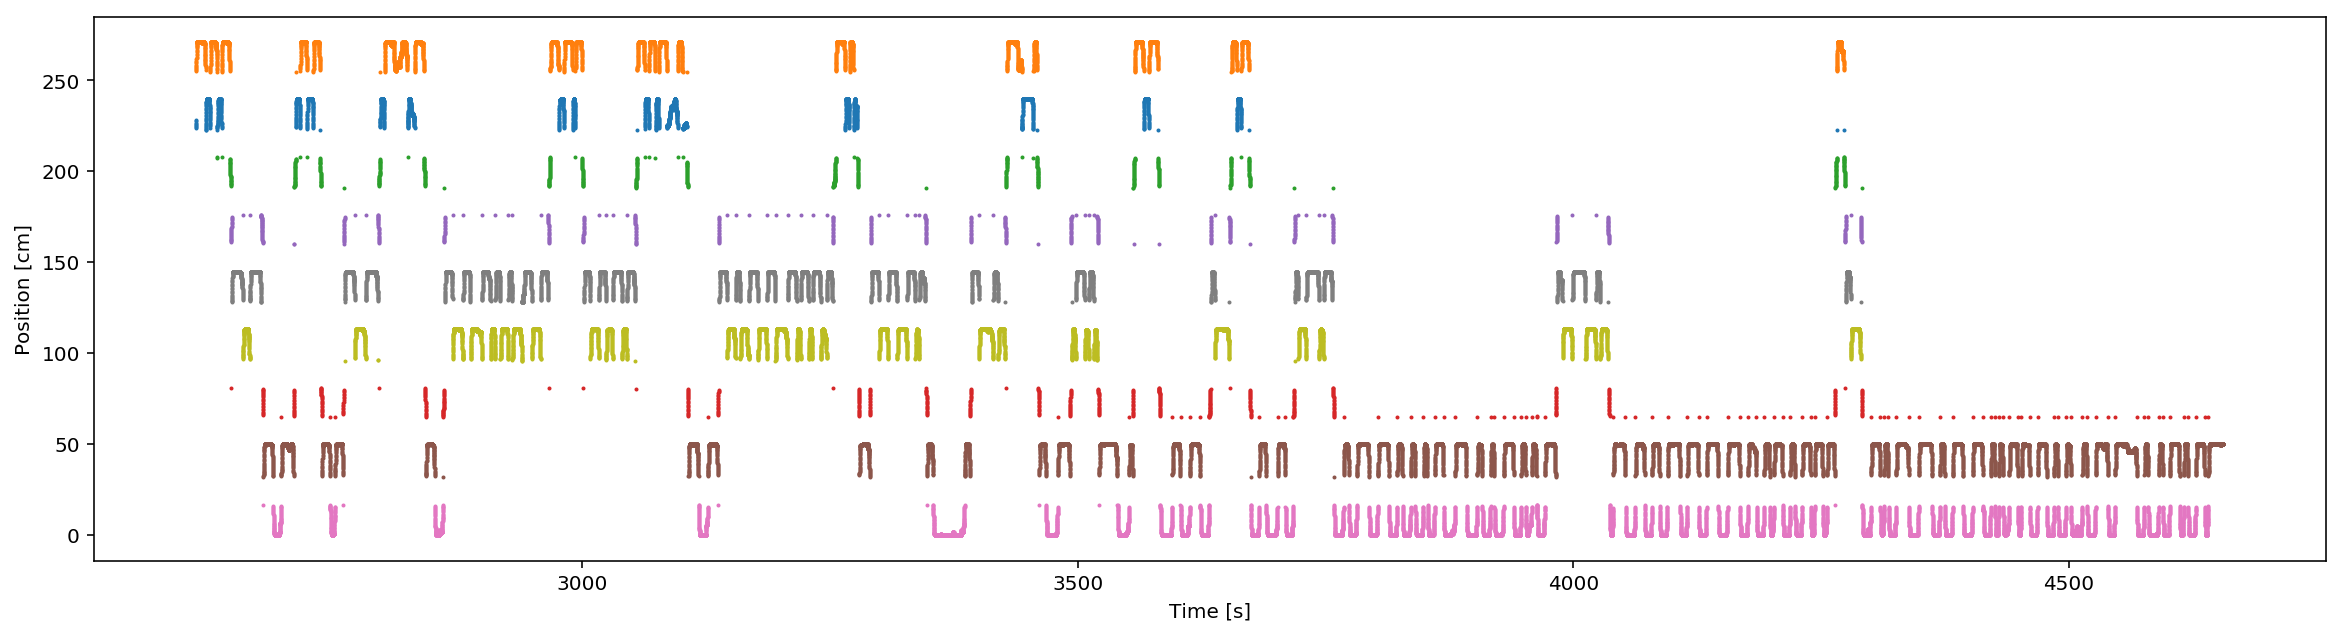

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))

for edge_label, df in position_info.groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');

## Compare to interpolated position

In [16]:
from src.load_data import get_interpolated_position_info

p = get_interpolated_position_info(epoch_key, ANIMALS)

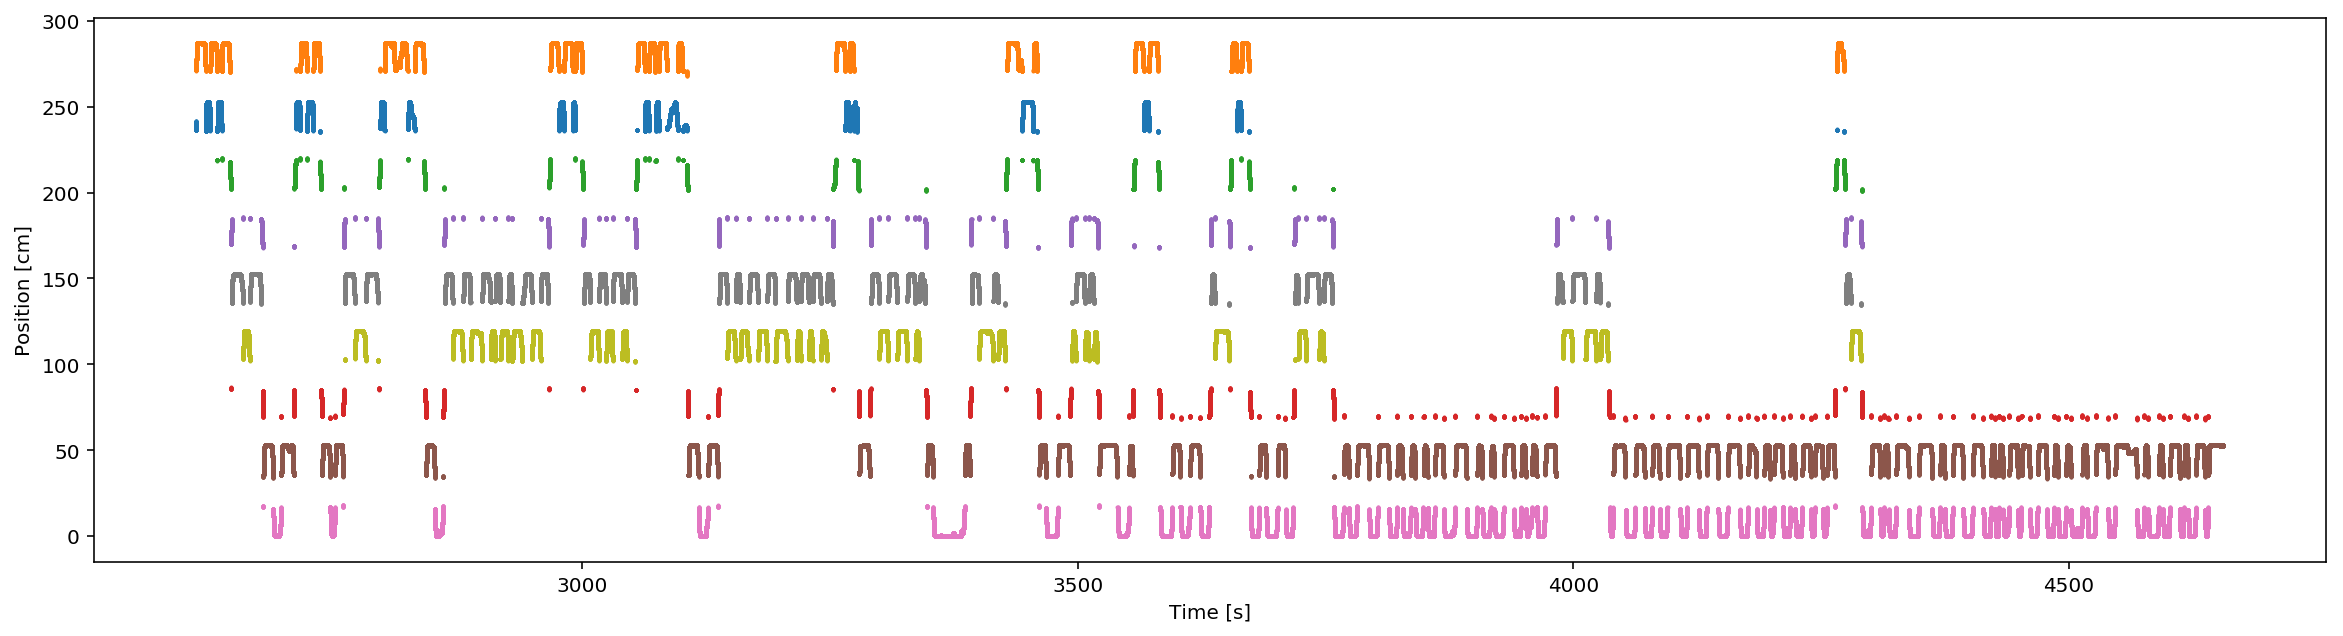

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))

for edge_label, df in p.groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');